In [1]:
import os
import sys
%cd /home/kaustubh/RuBisCO_ML/ESM_LoRA/analysis/
from lora_esm2_script_updated import *

/home/kaustubh/RuBisCO_ML/ESM_LoRA/analysis


In [2]:
class CustomModel(EsmPreTrainedModel):
    def __init__(self):
        super().__init__(EsmConfig.from_pretrained("facebook/esm2_t33_650M_UR50D"))
        self.backbone = EsmModel.from_pretrained("facebook/esm2_t33_650M_UR50D")

        self.outputs = torch.nn.Linear(320, 1)

    def forward(
        self,
        input_ids,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        labels=None,
        inputs_embeds=None,
        output_attentions=False,
        output_hidden_states=False,
        return_dict=True
    ):
        outputs = self.backbone(
            input_ids,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict
        )

        sequence_output = outputs.last_hidden_state # (B, L, 1280)
        bos_emb = sequence_output[:,0] # (B, L, 1280) -> (B, 1280)
        # outputs = [self.outputs[i](sequence_output) for i in range(5)]
        pred = self.outputs(bos_emb).squeeze(1) # (B,)

        # if labels, then we are training
        loss = None
        if labels is not None:
            assert pred.shape == labels.shape, f"{pred}, {labels}"
            loss_fn = torch.nn.BCEWithLogitsLoss(reduction="mean")
            loss = loss_fn(pred, labels.float())
            # loss = sum(losses)/len(losses)

        return {
            "loss": loss,
            "last_hidden_state": sequence_output,
            "logits": pred
        }

    def get_embedding(
        self,
        input_ids,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        labels=None,
        inputs_embeds=None,
        output_attentions=False,
        output_hidden_states=False,
        return_dict=True
    ):
        outputs = self.backbone(
            input_ids,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict
        )

        return outputs

In [14]:
model_path = "/home/kaustubh/RuBisCO_ML/ESM_LoRA/training_runs/esm2_t6_8M-finetuned-lora_2025-03-14_15-27-39"
base_model_path = "facebook/esm2_t6_8M_UR50D"

In [15]:
base_model = CustomModel()
loaded_model = PeftModel.from_pretrained(base_model, model_path)
loaded_model.eval()

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForTokenClassification(
  (base_model): LoraModel(
    (model): CustomModel(
      (backbone): EsmModel(
        (embeddings): EsmEmbeddings(
          (word_embeddings): Embedding(33, 320, padding_idx=1)
          (dropout): Dropout(p=0.0, inplace=False)
          (position_embeddings): Embedding(1026, 320, padding_idx=1)
        )
        (encoder): EsmEncoder(
          (layer): ModuleList(
            (0-5): 6 x EsmLayer(
              (attention): EsmAttention(
                (self): EsmSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=320, out_features=320, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=320, out_features=16, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (def

In [16]:
loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)

In [17]:
val_set_seqs = ['MSKRYTDYVDLNYTPKENDLICTFHIEPADGVDLEEAAGRVAAESSTGTWTDVSTMKPEIWEKLKARVYEIDESGNIVKIAYPLDLFEPGNIPQILSSIAGNIFGMKAVKNLRLLDIRFPKELVKSFKGPKFGIEGVRELLGVYDRPLVGTIVKPKVGLSAEEHAEVAYEAWVGGLDLVKDDENLTSQPFNPFEERVKKVLEARDKAEEETGEKKVYLVNITAPTEEMIRRAELVKDLGGKYVMIDIITAGFSAVQSLREEDLGLAIHAHRAMHAAFTRNPKHGISMLVLAKLARLVGVDQLHIGTGVGKMEGDKEEVLAIRDALRLDRVPADEANHFLEQDWYNIKPVFPVASGGLHPGLVPDLIDIFGKDVIIQAGGGVHGHPDGTRAGAKALRQAIEAAMEGISLEEYAKEHPELAKALEKWGHVP',
  'MSKRYTDYVDLNYTPKENDLICCFHIEPADGVDLEEAAGRVAAESSTGTWTDVSTMPEIWEKLKARVYEIDESGNIVKIAYPLDLFEPGNIPQILSSIAGNIFGMKAVKNLRLLDIRFPEELVKSFKGPKFGIEGVRELLGVYDRPLVGTIVKPKVGLSAEEHAEVAYEAWVGGLDLVKDDENLTSQPFNPFEERVKKVLEARDKAEEETGEKKVYLVNITAPTEEMIRRAELVKDLGGKYVMIDIITAGFSAVQSLREEDLGLAIHAHRAMHAAFTRNPKHGISMLVLAKLARLVGVDQLHIGTVVGKMEGDKEEVLAIRDALRLDRVPADEANHFLEQDWYNIKPVFPVASGGLHPGLVPDLIDIFGKDIIIQAGGGVHGHPDGTRAGAKAMRQAIEAAMEGISLEEYAKEHKELAKALEKWGHVRP',
  'MSGITYEDFLDLSYEPTDTDLVCTFRIEPAEGMSMEAAASRVASESSNGTWAALQVDDDITDLSATTFSIDGNTIKVAYPAGLFEAGNMPQILSCIAGNIMGMKAVDTIRLLDCEWPESIVSSFPGPQFGSSVRQEIFGVDDRPITATVPKPKVGLSTEQHAQIGYEAWVGGLDLLKDDENLTDQAFNPFEDRLTESLAMRDKAEDETGEKKSYLVNITAETNEMLERADMVAEQGGEYVMVDVITAGWAAVQTVRERCEDLGLAIHAHRAMHAAFDRLPSHGVSMRVLAQIARLCGVDQLHTGTAGLGKLANEDTVGINEWLRSDLYGMNDVLPVASGGLHPGLVPELLDAAGTNICIQAGGGIHGHPDGTRAGAKALRQAVDAAVEGVSIEEYADDHPELATALDKWGTETPR',
  'MSRYTDYVDLNYTPKENDLICTFHIEPADGVDLEEAAGRVAAESSIGTWTDVSTMPEIWEKLKARVYEIDESGNIVKIAYPLDLFEPGNIPQILSSIAGNIFGMKAVKNLRLLDIHFPKELVKSFKGPKFGIEGVRELLGVYDRPLVGTIVKPKVGLSAEEHAEVAYEAWVGGLDLVKDDENLTSQPFNPFEERVKKVLEARDKAEEETGEKKVYLVNITAPTEEMIRRAELVKDLGGKYVMIDIITAGFSAVQSLREEDLGLAIHAHRAMHAAFTRNPKHGISMLVLAKLARLVGVDQLHIGTVVGKMEGDKEEVLAIRDALRLDRVPADEANHFLEQDWYNIKPVFPVASGGLHPGLVPDLIDIFGKDIIIQAGGGVHGHPDGTRAGAKALRQAIEAAMEGISLEEYAKEHKELAKALEKWGHVRK',
  'MSRYTDYVDLNYTPKENDLICCFHIEPADGVDLEEAAGRVAAESSIGTWTDVSTMKPEIWEKLKARVYEIDESGNIVKIAYPLDLFEPGNIPQILSSIAGNIFGMKAVKNLRLLDIRFPKELVKSFKGPKFGIEGVRELLGVYDRPLVGTIVKPKVGLSAEEHAEVAYEAWVGGLDLVKDDENLTSQPFNPFEERVKKVMEARDKAEEETGEKKVYLVNITAPTEEMIRRAELVADLGGKYVMIDIITAGFSAVQSLREEDLGLAIHAHRAMHAAFTRNPKHGISMLVLAKLARLVGVDQLHIGTVVGKMEGDKEEVLAIRDALRLDRVPADEANHFLEQDWYNIKPVFPVASGGLHPGLVPDLIDIFGKDIIIQAGGGVHGHPDGTRAGAKAMRQAIEAVMEGISLEEYAKEHPELAKALEKWGHVRP',
  'MSRYTDYVDLNYTPKENDLICTFHIEPADGVDLEEAAGRVAAESSIGTWTDVSTMPEIWEKLKARVYEIDETGNIVKIAYPLDLFEPGNIPQILSSIAGNIFGMKAVKNLRLLDIRFPEELVKSFKGPKFGIEGVRELLGVYDRPLVGTIVKPKVGLSAEEHAEVAYEAWVGGIDLVKDDENLTSQPFNPFEERVKKVLEARDKAEEETGEKKVYLVNITAPTEEMIRRAELVADLGGKYVMIDIITAGFSAVQSLREEDLGLAIHAHRAMHAAFTRNPKHGISMLVLAKLARLVGVDQLHIGTVVGKMEGDKEEVLAIRDALRLDRVPADEANHFLEQDWYNIKPVFPVASGGLHPGLVPDLIDIFGKDVIIQAGGGVHGHPDGTRAGAKALRQAIEAAMEGISLEEYAKEHPELAKALEKWGHVR',
  'MSKRYTDYVDLNYTPKENDLICTFHIEPADGVDLEEAAGRVAAESSIGTWTDVSTMPEIVEKLKARVYEIDESGNIVKIAYPLDLFEPGNIPQILSSIAGNIFGMKAVKNLRLLDIRFPKELVKSFKGPKFGIEGVRELLGVYDRPLVGTIVKPKVGLSAEEHAEVAYEAWVGGLDLVKDDENLTSQPFNPFEERVKKTLEARDKAEEETGEKKVYLVNITAPTEEMIRRAELVKDLGGKYVMIDIITAGFSAVQSLREEDLGLAIHAHRAMHAAFTRNPKHGISMLVLAKLARLVGVDQLHIGTGVGKMEGDKEEVLAIRDALRLDRVPADEANHFLEQDWYNIKPVFPVASGGLHPGLVPDLIDIFGKDIIIQAGGGVHGHPDGTRAGAKAMRQAIEAAMEGISLEEYAKEHPELAKALEKWGHVR',
  'MSKRYTDFIDLNYTPKENDLICTFHIEPADGVDLEEAAGRVAAESSIGTWTDVSTMPEIWEKLKARVYEIDESGNIVKIAYPLDLFEPGNIPQILSSIAGNIFGMKAVKNLRLLDIRFPKELVKSFKGPKFGIEGVRELLGVYDRPLVGTIVKPKVGLSAEEHAEVAYEAWVGGLDLVKDDENLTSQPFNPFEERVKKVLEARDKAEEETGEKKVYLVNITAPTEEMIRRAELVKDLGGKYVMIDIITAGFSAVQSLREEDLGLAIHAHRAMHAAFTRNPKHGISMLVLAKLARLVGVDQLHIGTGVGKMEGDKEEVLAIRDALRLDRVPADEANHFLEQDWYNIKPVFPVASGGLHPGLVPDLIDIFGKDVIIQAGGGVHGHPDGTRAGAKALRQAIEAAMEGISLEEYAKEHPELKKALEKWGHVRP']
val_set_labels = [0, 1, 0, 0, 0, 0, 0, 1]

In [23]:
output_emb = []

for i in range(len(val_set_seqs)):
    inputs = loaded_tokenizer(val_set_seqs[i], truncation=True, padding='max_length', max_length=512, return_tensors="pt")
    labels = [val_set_labels[i]]

    with torch.no_grad():
        outputs = loaded_model(**inputs)["last_hidden_state"].squeeze(0)[0]
        outputs = outputs.cpu().numpy()
        # Sigmoid activation
        # outputs = 1 / (1 + np.exp(-outputs))
        # print(outputs, labels)

        output_emb.append(outputs)



In [38]:
np.array(output_emb).shape

(8, 320)

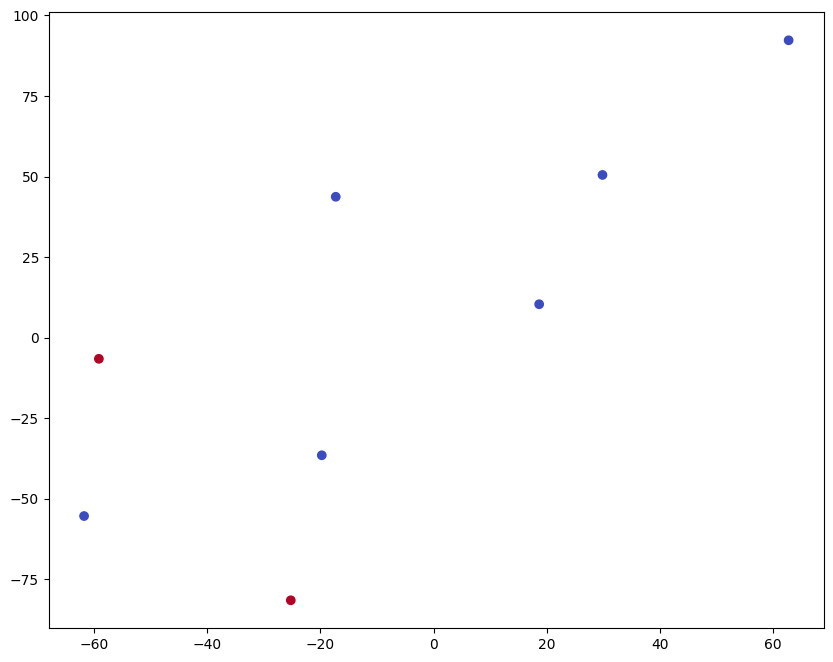

In [43]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
# import umap
import matplotlib.pyplot as plt

distance_matrix = pairwise_distances(output_emb, metric="cosine")
tsne = TSNE(n_components=2, metric="precomputed", init="random", random_state=42, perplexity=5)
tsne_embedding = tsne.fit_transform(distance_matrix)
# umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, metric="cosine")
# tsne_embedding = umap_model.fit_transform(output_emb)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=val_set_labels, cmap="coolwarm")

In [30]:
tsne_embedding[:, 1]

array([-36.505833,  -6.570025,  92.29065 ,  10.369466,  43.720005,
        50.494823, -55.363346, -81.50934 ], dtype=float32)

In [2]:
concat_all_exp_data = pd.read_pickle('/home/kaustubh/RuBisCO_ML/ESM_LoRA/data/processed_combined_all_exp_assays_data.pkl')

formIII_lsu_variant_data_df = concat_all_exp_data.query('LSU_id.str.startswith("Anc393") or LSU_id.str.startswith("Anc367") or LSU_id == "Anc367" or LSU_id == "Anc366"')
formIII_lsu_variant_data_df['fixed_threshold_activity'] = formIII_lsu_variant_data_df['mean_reading'].apply(lambda x: 1 if x >= 50 else 0)


/tmp/ipykernel_3873108/474199619.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  formIII_lsu_variant_data_df['fixed_threshold_activity'] = formIII_lsu_variant_data_df['mean_reading'].apply(lambda x: 1 if x >= 50 else 0)


In [4]:
esm2_emb_all = formIII_lsu_variant_data_df['lsussu_esm2'].to_list()
binary_labels = formIII_lsu_variant_data_df['fixed_threshold_activity'].to_list()

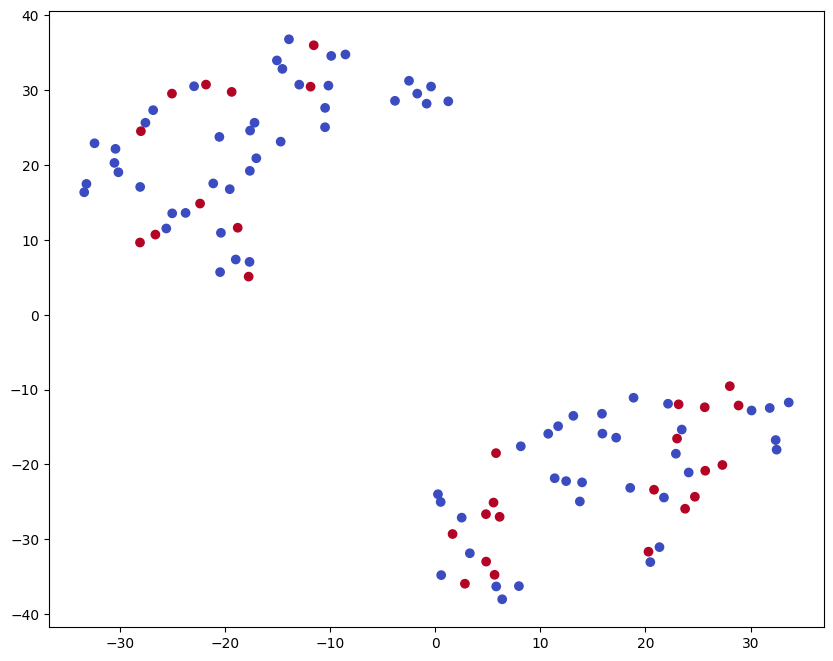

In [5]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
# import umap
import matplotlib.pyplot as plt

distance_matrix = pairwise_distances(esm2_emb_all, metric="cosine")
tsne = TSNE(n_components=2, metric="precomputed", init="random", random_state=42, perplexity=5)
tsne_embedding = tsne.fit_transform(distance_matrix)
# umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, metric="cosine")
# tsne_embedding = umap_model.fit_transform(output_emb)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=binary_labels, cmap="coolwarm")